In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from neo.io import AxonIO
import os
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

from utils import *
plt.style.use('pcb')

In [2]:
def rescale(arr, baseline=None):
    if baseline is None:
        return arr / arr.max()
    else:
        return (arr-baseline) / (arr-baseline).max()

In [48]:
odors = ['acetone','apinene','linalool']
files_duration = ['data/PID/durations/' + x + '.abf' for x in odors]
files_block = ['data/PID/block/' + x for x in os.listdir('data/PID/block/') if x[-3:]=='abf']

In [49]:
def read_file(file, valve_ix=0, valve_cutoff=5, filter_cutoff=None):
    if valve_ix == 1:
        pid_ix = 0
    elif valve_ix == 0:
        pid_ix = 1
    
    reader = AxonIO(filename=file)
    seg = reader.read_segment()
    
    valve = np.array(seg.analogsignals[valve_ix])[:,0]
    pid = np.array(seg.analogsignals[pid_ix])[:,0]
    
    if filter_cutoff is not None:
        pid = butter_lowpass_filter(pid, fs=1e3, cutoff=filter_cutoff)
    
    tarr = np.arange(len(pid))*1e-3
    valve_on = valve > valve_cutoff
    openings = tarr[:-1][~valve_on[:-1] & valve_on[1:]]
    closings = tarr[:-1][valve_on[:-1] & ~valve_on[1:]]
    
    return tarr, pid, openings, closings

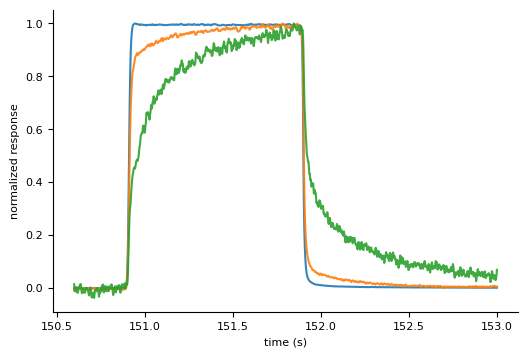

In [51]:
fig, ax = plt.subplots()

def plot_compounds(ax):
    compounds = ['acetone', r'$\alpha$-pinene', 'linalool']

    for ix, odor in zip([0,1,2], compounds):
        tarr, pid, openings, closings = read_file(files_duration[ix])

        fs = 1/(tarr[1] - tarr[0])

        mask = (tarr >= 150.6) & (tarr < 153)
        mask_baseline = (tarr >= 150.) & (tarr < 150.5)
        filtered = butter_lowpass_filter(pid[mask], fs=fs, cutoff=45)
        baseline = pid[mask_baseline].mean()

        ax.plot(tarr[mask], rescale(filtered, baseline), alpha=0.9, label=odor)

        ax.set_ylabel('normalized response')
        ax.set_xlabel('time (s)')
    

plot_compounds(ax)

In [52]:
# block_file_ix = 0
# valve_ix = 1
# file = files_block[block_file_ix]
# tarr, pid, openings, closings = read_file(file, valve_ix, valve_cutoff=0.5, filter_cutoff=50)

In [60]:
def find_end(tarr, pid, opening, closing):
    resp_mask = (tarr > opening) & (tarr < closing+0.5)
#     plt.plot(tarr[resp_mask], pid[resp_mask])

    base = pid[resp_mask].min()
    resp_max = pid[resp_mask].max()

    cross_val = (resp_max-base)*0.95 + base
    
    return tarr[resp_mask][np.argwhere((pid[resp_mask][:-1] > cross_val) & (pid[resp_mask][1:] < cross_val))[-1]][0]
#     plt.axvline(tarr[np.argwhere((pid[:-1] > cross_val) & (pid[1:] < cross_val))[-1]])
# plt.ylim(-0.44,-0.42)

In [61]:
def func(x, a1, t1, a2, t2, b):
    return a1*np.exp(-x/t1)+a2*np.exp(-x/t2)+b

def analyze_durations(experiment=0, eval_time=1):
    if experiment == 0:
        valve_ix = 1
        openings_shift = 0
        level_cross = 0.6
        block_file_ix = 0
        file = files_block[block_file_ix]
    elif experiment == 1:
        valve_ix = 0
        openings_shift = 1
        level_cross = -0.465
        file = files_duration[2]

    tarr, pid, openings, closings = read_file(file, valve_ix, valve_cutoff=0.5, filter_cutoff=50)
    
    openings, closings = openings[openings_shift:], closings[openings_shift:]

    dt = tarr[1] - tarr[0]
    fs = 1 / dt

    mask = (tarr >= 0) & (tarr < 800)
    mask_baseline = (tarr >= 20) & (tarr < 25)
    filtered = butter_lowpass_filter(pid[mask], fs=fs, cutoff=25)
    
    ends = []
    for opening, closing in zip(openings, closings):
        end = find_end(tarr, pid, opening, closing)
#         print(end)
        ends.append(end)
        
    ends = np.array(ends)
    
#     baseline = pid[mask_baseline].mean()

#     shift = 2
#     crossings = tarr[:-shift][(pid[:-shift] > level_cross) & (pid[shift:] < level_cross)]
#     crossings = np.insert(crossings, 0, 0)
#     ends = crossings[1:][np.diff(crossings) > 1e-1]
    durations = ends - openings
#     print(durations)
    res = {}

    for i, (dur, op, end) in enumerate(zip(durations, openings, ends)):
        xx = tarr - end
        mask = (xx > 0) & (xx < 4)
        yy = pid[mask]
        start = ((yy[0]-yy[-1]), 0.005, 0, 0.2, yy[-1])
        
        try:
            popt, pcov = curve_fit(func, xx[mask], pid[mask], p0=start)
        except:
            import pdb;pdb.set_trace()
    
        mask_val = (xx > eval_time-0.01) & (xx < eval_time+0.01)
        mask_finish = (xx > -0.2) & (xx < 0)
        mask_base = (xx+end > op-2) & (xx+end < op-0.1)

        
        base = popt[-1]
        val_at_1s = pid[mask_val].mean() - base

        peak = pid[mask_finish].max()-base

        res[dur] = (*popt, base, val_at_1s/peak, peak, val_at_1s, end)
        
    res_df = pd.DataFrame(res, index=['a1', 't1', 'a2', 't2', 'b', 'base', '1s_decrease', 'peak', 'sust', 'end']).T
    
    return res_df.sort_index()

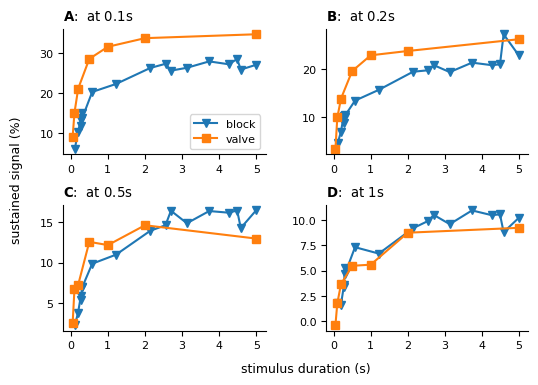

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, gridspec_kw={'wspace': 0.3, 'hspace': 0.4})

def plot_comparisons(axes, letters=None, **kwargs):
    if letters is None:
        letters = ['A','B','C','D']
    
    for ax, time, l in zip(axes.flat, [0.1, 0.2, 0.5, 1], letters):
        df0 = analyze_durations(0, time)
        df1 = analyze_durations(1, time)

        (100*df0['1s_decrease']).plot(marker='v', label='block', ax=ax, **kwargs)
        (100*df1['1s_decrease']).plot(marker='s', label='valve', ax=ax, **kwargs)

        ax.set_title(fr'$\mathbf{{{l}}}$:  ' + f'at {time}s', loc='left')

    axes[1,0].set_xlabel('stimulus duration (s)', fontsize=9)
    axes[1,0].xaxis.set_label_coords(1.2, -0.25)

    axes[1,0].set_ylabel('sustained signal (%)', fontsize=9)
    axes[1,0].yaxis.set_label_coords(-0.2, 1.2)
    
plot_comparisons(axes)

axes[0,0].legend()

In [63]:
_tarr, _pid, _openings, _closings = read_file(files_duration[2])
duration_color_index = UnivariateSpline(_closings - _openings, np.linspace(0,1,len(_closings)), s=0, k=1)

In [71]:
block_file_ix = 2

def plot_blocking_trace(ax, valve_ix=0):
    tarr, pid, openings, closings = read_file('data/PID/block_experiment.abf', valve_ix)
    dt = tarr[1] - tarr[0]
    fs = 1 / dt

    mask = (tarr >= 25) & (tarr < 80)
    mask_baseline = (tarr >= 20) & (tarr < 25)
    filtered = butter_lowpass_filter(pid[mask], fs=fs, cutoff=25)
    baseline = pid[mask_baseline].mean()

    ax.plot(tarr[mask], filtered - baseline, alpha=0.9)

    for o, c in zip(openings[:4], closings[:4]):
        ax.axvspan(o, c, alpha=0.2)
    
    ax.set_ylabel(r'$\Delta\,$PID (mV)')
    ax.set_xlabel('time (s)')

plot_blocking_trace(axes[0])

In [68]:
def plot_blocking_traces_overlay(ax):
    block_file_ix = 0
    valve_ix = 1
    file = files_block[block_file_ix]
    tarr, pid, openings, closings = read_file(file, valve_ix, valve_cutoff=0.5, filter_cutoff=49)
    
    ends = []
    starts = []

    for opening, closing in zip(openings, closings):
        end = find_end(tarr, pid, opening, closing)
    #         print(end)
        ends.append(end)
        starts.append(opening)
    
    starts = np.array(starts)
    ends = np.array(ends)
    durations = ends - starts
    
    oed_sorted = np.array(sorted([(o,e,d) for o, e, d in zip(openings, ends, durations)], key=lambda x: x[2]))
    
    cmap = get_cmap('viridis')
#     colors = [cmap(x) for x in np.linspace(0,1,len(oed_sorted))]

    for i, (o, e, d) in enumerate(oed_sorted):
        color = cmap(duration_color_index(d))
        mask = (tarr-e > -8) & (tarr-e <0.5)
        x = tarr[mask]-e
        y = pid[mask]
        base = y[(x<-d-0.5) & (x>-d-2.5)].mean()
        rescaled_y = rescale(y-base)
        ax.plot(x, rescaled_y, color=color)

    # plt.axhline(0.21)
    ax.set_xlim(-0.4,0.5)

    ax.set_ylabel('pid')
    ax.set_xlabel('time after stim offset')

In [65]:
duration_dict = {
    0.02: '20ms',
    0.05: '50ms',
    0.1: '100ms',
    0.2: '200ms',
    0.5: '500ms',
    1: '1s',
    2: '2s',
    5: '5s',
}

duration_strs = ['20ms', '50ms', '100ms', '200ms', '500ms', '1s', '2s', '5s']

def plot_duration_ends(ax, ix=8, normalize=False, cutoff=None, gain_factor=1, before=0.4, after=0.5, **kwargs):
    tarr, pid, openings, closings = read_file(files_duration[ix])
    dt = tarr[1] - tarr[0]
    fs = 1 / dt
    
    cmap = get_cmap('viridis')
    colors = [cmap(x) for x in np.linspace(0,1,len(openings))]

    for op, cl, color, dur_str in zip(openings, closings, colors, duration_strs):
        start = cl - before
        end = cl + after
#         start = op - 0.4
#         end = op + 0.5
        mask = (tarr >= start) & (tarr < end)
        mask_baseline = (tarr >= op-2) & (tarr < op)
        baseline = pid[mask_baseline].mean()
    #     filtered = butter_lowpass_filter(pid[mask]-baseline, fs=fs, cutoff=200)
        
        if cutoff is not None:
            trace = butter_lowpass_filter(pid-baseline, fs=fs, cutoff=cutoff)[mask]
        else:
            trace = pid[mask]-baseline
        
        if normalize:
            ax.plot(tarr[mask]-start, rescale(trace), label=dur_str, color=color, **kwargs)
        else:
            ax.plot(tarr[mask]-start, trace*gain_factor, label=dur_str, color=color, **kwargs)

    ax.set_xlabel('time (s)')
    
    if not normalize:
        ax.set_ylabel(r'$\Delta\,$PID (mV)')
    else:
        ax.set_ylabel('normalized response')

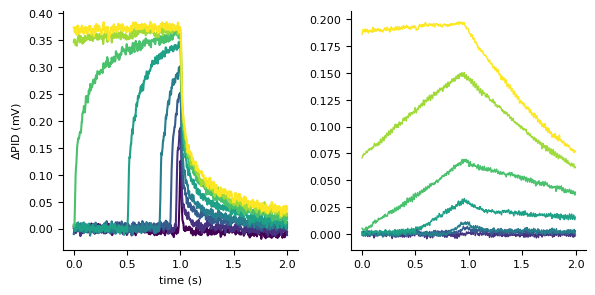

In [70]:
def glass_pid_plot(ax, start, stop, **kwargs):
    file = 'data/PID/glass tube/22704023.abf'

    tarr, pid, openings, closings = read_file(file, valve_ix=1, filter_cutoff=49)
    
    mask = (tarr > start) & (tarr < stop)
    mask_base = (tarr > start-5) & (tarr < start-4)
    baseline = pid[mask_base].mean()
    ax.plot(tarr[mask]-tarr[mask][0], pid[mask] - baseline, linestyle='-', **kwargs)
    
def plot_old_new_comparison(axes):
    file = 'data/PID/glass tube/22704023.abf'

    tarr, pid, openings, closings = read_file(file, valve_ix=1, filter_cutoff=49)
    
    cmap = get_cmap('viridis')

    durations = ['100ms', '200ms', '500ms', '1s', '2s', '5s']

    for opn, close in zip(openings[1:], closings[1:]):
        d = close - opn

        color = cmap(duration_color_index(d))

        stop = close + 1.5
        start = close-0.5

        glass_pid_plot(axes[1], start, stop, color=color, lw=1.)

    plot_duration_ends(axes[0], ix=2, normalize=False, cutoff=49, lw=1.5, gain_factor=5, before=1., after=1.)

    axes[1].set_ylabel('')
    axes[0].set_ylabel(r'$\Delta$'+'PID (mV)')
    axes[0].set_xlabel('time (s)')

fig, axes = plt.subplots(ncols=2, figsize=(6,3))
plot_old_new_comparison(axes)
fig.tight_layout()

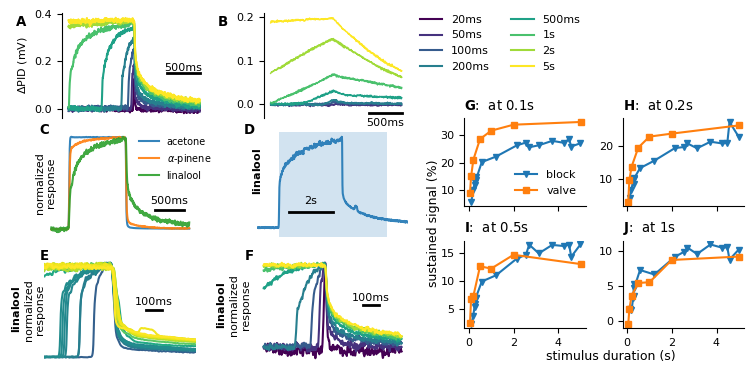

In [72]:
fig = plt.figure(figsize=(7,3.5))

gs_left = fig.add_gridspec(1,2, top=1, bottom=0.7, left=0.025, right=0.52, hspace=0.2, wspace=0.4)
axes = np.array([fig.add_subplot(gs_left[i]) for i in range(2)])

plot_old_new_comparison(axes)
axes[0].legend(frameon=False, ncol=2, loc=(2.45,0.4))

axes[0].plot([1.5,2],[0.15,0.15], color='black', lw=2)
axes[0].text(1.75, 0.16, '500ms', ha='center')

axes[1].plot([1.5,2],[-0.02,-0.02], color='black', lw=2, clip_on=False)
axes[1].text(1.75, -0.05, '500ms', ha='center')

for ax in axes:
    despine_ax(ax, 'b')
    ax.set_xlabel('')
    
axes[0].set_title('A', loc='left', fontweight='bold', x=-0.32, y=0.8)
axes[1].set_title('B', loc='left', fontweight='bold', x=-0.32, y=0.8)


gs_left = fig.add_gridspec(2,2, top=0.66, bottom=0.0, left=0, right=0.52, hspace=0.2, wspace=0.4)
    
axes = np.array([[fig.add_subplot(gs_left[j,i]) for i in range(2)] for j in range(2)])

plot_compounds(axes[0,0])
plot_duration_ends(axes[1,1], ix=2, normalize=True, cutoff=49)
plot_blocking_trace(axes[0,1])
plot_blocking_traces_overlay(axes[1,0])

axes[0,1].set_xlim(53, 60)


# axes[1,1].legend(frameon=False, loc=(0.5,0.5))
axes[0,0].legend(frameon=False, loc=(0.6,0.5), fontsize=7)

axes[0,0].plot([151.2+1.2, 151.7+1.2],[0.2,0.2], color='black', lw=2)
axes[0,0].text(151.45+1.2, 0.27, '500ms', ha='center')

axes[1,1].plot([0.65, 0.75],[0.5,0.5], color='black', lw=2)
axes[1,1].text(0.7, 0.55, '100ms', ha='center')

axes[0,1].plot([54.5, 56.5],[0.1,0.1], color='black', lw=2)
axes[0,1].text(55.5, 0.15, '2s', ha='center')

# axes[1,0].plot([78, 78],[0.2,0.3], color='black', lw=2)
# axes[1,0].text(79, 0.25, '0.1mV', va='center', ha='left')

axes[1,0].plot([0.2, 0.3],[0.5,0.5], color='black', lw=2)
axes[1,0].text(0.25, 0.55, '100ms', ha='center')

axes[0,0].text(150.5, 0.5, 'normalized\nresponse', rotation=90, va='center', ha='center')
axes[1,1].text(-0.2, 0.5,  r'$\bf{linalool}$' + '\n' + 'normalized\nresponse', rotation=90, va='center', ha='center')
axes[0,1].text(53, 0.35, r'$\bf{linalool}$', rotation=90, va='center', ha='center')
axes[1,0].text(-0.5, 0.5, r'$\bf{linalool}$' + '\n' + 'normalized\nresponse', rotation=90, va='center', ha='center')

# despine_ax(axes[0,1], where='l', remove_ticks=True)

letters = ['C','D','E','F']
xpositions = [0, -0.05, 0, -0.05]

for ax, l, xpos in zip(axes[:2,:2].flat, letters, xpositions):
    ax.set_title(l, x=xpos, y=0.9, fontweight='bold')
    
# axes[0,1].set_title('linalool', loc='right')
# axes[1,0].set_title('linalool', loc='right')

for ax in axes[:,:2].flat:
    despine_ax(ax, remove_ticks=True)
    ax.set_xlabel('')
    ax.set_ylabel('')

gs_right = fig.add_gridspec(2,2, top=0.7, bottom=0.1, left=0.6, right=1, hspace=0.4, wspace=0.3)
axes = np.array([[fig.add_subplot(gs_right[j,i]) for i in range(2)] for j in range(2)])
    
plot_comparisons(axes[:,:], letters=['G','H','I','J'], ms=5)
axes[0,0].legend(frameon=False)

for ax in axes[0,:]:
    ax.set_xticklabels([])